In [46]:
pip install pytorch-pretrained-bert

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import os, sys
import json
import matplotlib.pyplot as plt
import pandas as pd
import string
import torch

from collections import defaultdict
from random import sample 
from torch.nn import functional as F
from pytorch_pretrained_bert import  GPT2Tokenizer, GPT2LMHeadModel, BertTokenizer, BertForPreTraining, OpenAIAdam

sys.path.insert(0, "/content/gdrive/My Drive/Project-Lion/") 
root_folder = "/content/gdrive/My Drive/Project-Lion/"

In [0]:
def clean_data(lst, in_place=True, keep_punc=""):
    if in_place:
        new_lst = lst
    else:
        new_lst = lst.copy()
        
    for i in range(len(new_lst)):
        joke = lst[i]
        joke = joke.replace("\r", " ").replace("\n", " ").replace("/", " or ")
        punc_to_remove = string.punctuation
        for punc in keep_punc:
          punc_to_remove = punc_to_remove.replace(punc, "")
        joke = joke.translate(str.maketrans("", "", punc_to_remove)) # Remove punctuation
        joke = joke.lower() # Lowercase
        joke = joke.strip() # Remove leading and ending whitespace
        new_lst[i] = joke
    return new_lst

In [0]:
df = pd.read_csv(root_folder + 'data/kaggle/shortjokes.csv')
df = df.loc[df["Joke"] != ""]

In [51]:
data = clean_data(df["Joke"].tolist(), keep_punc="?,':.")
print("Length of data:", len(data))
print(data[0])

Length of data: 231657
me narrating a documentary about narrators i can't hear what they're saying cuz i'm talking


# GPT

In [0]:
best_path = root_folder + "gpt_output/gpt_finetuning_with_validation/best_model.pt"
best_train_losses_path = root_folder + "gpt_output/gpt_finetuning_with_validation/best_train_losses"
best_val_losses_path = root_folder + "gpt_output/gpt_finetuning_with_validation/best_val_losses"
latest_path = root_folder + "gpt_output/gpt_finetuning_with_validation/latest_model.pt"
latest_train_losses_path = root_folder + "gpt_output/gpt_finetuning_with_validation/latest_train_losses"
latest_val_losses_path = root_folder + "gpt_output/gpt_finetuning_with_validation/latest_val_losses"

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
saved_model = GPT2LMHeadModel.from_pretrained('gpt2')
optimizer = OpenAIAdam(model.parameters(), lr=0.001)
iteration = 1
train_losses = []
val_losses = []

t_total value of -1 results in schedule not being applied


In [0]:
train_size = len(data) * 6 / 7

gpt_train_data = defaultdict(list) # Map from length of data -> list of data
gpt_val_data = defaultdict(list) 

for i in range(len(data)):
  d = data[i]
  tokens = tokenizer.encode(d)
  if len(tokens) > 6 and len(tokens) < 50:
    if i < train_size:
      gpt_train_data[len(tokens)].append(tokens)
    else:
      gpt_val_data[len(tokens)].append(tokens)

gpt_train_data = dict(gpt_train_data)
gpt_train_data_lens = list(gpt_train_data.keys())
gpt_val_data = dict(gpt_val_data)
gpt_val_data_lens = list(gpt_val_data.keys())

weighted_gpt_train_data_lens = []
for lens in gpt_train_data_lens:
  weighted_gpt_train_data_lens.extend([lens] * len(gpt_train_data[lens]))
  
weighted_gpt_val_data_lens = []
for lens in gpt_val_data_lens:
  weighted_gpt_val_data_lens.extend([lens] * len(gpt_val_data[lens]))

In [10]:
print("Training data size:", len(weighted_gpt_train_data_lens))
print("Validation data size:", len(weighted_gpt_val_data_lens))

Training data size: 196955
Validation data size: 32786


In [11]:
a_train = []
for lens in gpt_train_data_lens:
  a_train.append((lens, len(gpt_train_data[lens])))
  
a_val = []
for lens in gpt_val_data_lens:
  a_val.append((lens, len(gpt_val_data[lens])))
  
min_tup_train = min(a_train, key=lambda x: x[1])
min_tup_val = min(a_val, key=lambda x: x[1])
  
print("Training - Length with smallest batch: {0}. Length of batch: {1}".format(min_tup_train[0], min_tup_train[1]))
print("Validation - Length with smallest batch: {0}. Length of batch: {1}".format(min_tup_val[0], min_tup_val[1]))

Training - Length with smallest batch: 49. Length of batch: 232
Validation - Length with smallest batch: 49. Length of batch: 33


## Load Previous Latest model

Run to load most recent model to continue training

In [0]:
checkpoint = torch.load(latest_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
iteration = checkpoint['iteration'] + 1
loss = checkpoint['loss']
train_losses = np.load(latest_train_losses_path + ".npy").tolist()
val_losses = np.load(latest_val_losses_path + ".npy").tolist()

## Training

In [13]:
train_batch_size = 32
val_batch_size = 32
keep_model_trials = 5
epochs = 20
iterations_per_epoch = 1000
total_iterations = (iterations_per_epoch * epochs) + iteration - 1

for epoch in range(1, epochs + 1):
  for _ in range(iterations_per_epoch):

    length = np.random.choice(weighted_gpt_train_data_lens)
    batch_input = torch.tensor(sample(gpt_train_data[length], train_batch_size))

    loss = model(batch_input, lm_labels=batch_input)
    train_losses.append((iteration, loss.data.item()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration % 10 == 0:
      print("Iteration {0}/{1}: Loss - {2}".format(str(iteration), total_iterations, str(loss.data.item())))
      
    if iteration % 100 == 0:
      curr_loss, saved_loss = 0, 0
      for _ in range(keep_model_trials):
        length = np.random.choice(weighted_gpt_val_data_lens)
        batch_input = torch.tensor(sample(gpt_val_data[length], val_batch_size))

        checkpoint = torch.load(best_path)
        saved_model.load_state_dict(checkpoint['model_state_dict'])
        saved_model_loss = saved_model(batch_input, lm_labels=batch_input).data.item()
        model_loss = model(batch_input, lm_labels=batch_input).data.item()
        
        curr_loss, saved_loss = curr_loss + model_loss, saved_loss + saved_model_loss
        
      avg_curr_loss, avg_saved_loss = curr_loss / keep_model_trials, saved_loss / keep_model_trials
      loss_str = "Average current model loss: {0}. Average saved model loss: {1}. ".format(avg_curr_loss, avg_saved_loss)
      
      val_losses.append((iteration, avg_curr_loss))
      
      if avg_curr_loss < avg_saved_loss:
        print(loss_str + "Updating best model.")
        torch.save({
              'epoch': epoch,
              'iteration': iteration,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss
              }, best_path)
        
        np.save(best_train_losses_path, train_losses)
        np.save(best_val_losses_path, val_losses)
        
      else:
        print(loss_str + "Keeping previous best model.")
        
      torch.save({
            'epoch': epoch,
            'iteration': iteration,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, latest_path)
      
      np.save(latest_train_losses_path, train_losses)
      np.save(latest_val_losses_path, val_losses)
        
    iteration += 1
    

Iteration 9510/29500: Loss - 2.399461507797241
Iteration 9520/29500: Loss - 3.415865182876587
Iteration 9530/29500: Loss - 2.724057197570801
Iteration 9540/29500: Loss - 2.693467140197754
Iteration 9550/29500: Loss - 3.0270423889160156
Iteration 9560/29500: Loss - 3.5230624675750732
Iteration 9570/29500: Loss - 2.801056385040283
Iteration 9580/29500: Loss - 3.3204121589660645
Iteration 9590/29500: Loss - 2.6354641914367676
Iteration 9600/29500: Loss - 3.3820719718933105
Average current model loss: 3.522420597076416. Average saved model loss: 3.557790660858154. Updating best model.
Iteration 9610/29500: Loss - 3.0922203063964844
Iteration 9620/29500: Loss - 2.8020617961883545
Iteration 9630/29500: Loss - 3.086568593978882
Iteration 9640/29500: Loss - 2.2697863578796387
Iteration 9650/29500: Loss - 2.6908209323883057
Iteration 9660/29500: Loss - 2.7342865467071533
Iteration 9670/29500: Loss - 2.5063493251800537
Iteration 9680/29500: Loss - 2.4366679191589355
Iteration 9690/29500: Loss - 

KeyboardInterrupt: ignored

## Load Best Model

In [12]:
checkpoint = torch.load(best_path)
saved_model.load_state_dict(checkpoint['model_state_dict'])
best_train_losses = np.load(best_train_losses_path + ".npy").tolist()
best_val_losses = np.load(best_val_losses_path + ".npy").tolist()
print("Number of Iterations:", checkpoint['iteration'])

Number of Iterations: 10000


## Plot

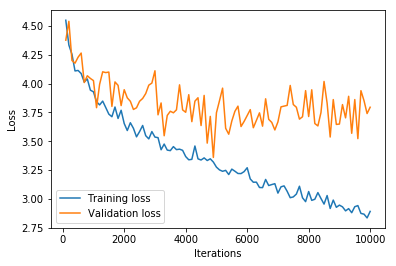

In [63]:
x_train = []
y_train, y_sum = [], []
for x, y in best_train_losses:
  y_sum.append(y)
  if x % 100 == 0:
    x_train.append(x)
    y_train.append(sum(y_sum) / 100)
    y_sum = []
    
x_val, y_val = [], []
for x, y in best_val_losses:
  x_val.append(x)
  y_val.append(y)
  
plt.plot(x_train, y_train, label="Training loss")
plt.plot(x_val, y_val, label="Validation loss")
plt.legend(loc="lower left")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## Evaluation

In [16]:
batch_size = 32
length = np.random.choice(weighted_gpt_val_data_lens)
batch_input = torch.tensor(sample(gpt_val_data[length], batch_size))
saved_model_loss = saved_model(batch_input, lm_labels=batch_input).data.item()
print(saved_model_loss)

3.249004364013672


## Generate Text

In [55]:
text = tokenizer.encode("why did the")
input, past = torch.tensor([text]), None
for _ in range(30):
  logits, past = saved_model(input, past=past)
  input = torch.multinomial(F.softmax(logits[:, -1]), 1)
  text.append(input.item())
  
tokenizer.decode(text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


"why did the energizer bunny ask his girlfriend? beats her. because she's very attractive. bonus: elo ren is my girlfriend. :p . . ."

In [0]:
text = tokenizer.encode("why did the")



# BERT

In [0]:
!python /content/gdrive/My\ Drive/Project-Lion/pytorch-pretrained-BERT-master/examples/lm_finetuning/simple_lm_finetuning.py --train_corpus gdrive/My\ Drive/Project-Lion/bert_training_data.txt --bert_model bert-base-uncased --num_train_epochs 4.0 --do_lower_case --output_dir gdrive/My\ Drive/Project-Lion/gpt_output/ --do_train

Traceback (most recent call last):
  File "/content/gdrive/My Drive/Project-Lion/pytorch-pretrained-BERT-master/examples/lm_finetuning/simple_lm_finetuning.py", line 34, in <module>
    from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
ImportError: cannot import name 'warmup_linear'


In [0]:
model = BertForPreTraining.from_pretrained(root_folder + "gpt_output/")

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = bert_tokenizer.basic_tokenizer

In [0]:
tokens = tokenizer.tokenize("Why did the chicken")

In [0]:
ids = bert_tokenizer.convert_tokens_to_ids(tokens)

In [0]:
text = []
input = torch.tensor([ids])
output1, output2 = model(input)
print(output1.shape)
a = torch.multinomial(F.softmax(output1[:, 3]), 1)
text.append(a.item())
print(text)
print(bert_tokenizer.convert_ids_to_tokens(text))

torch.Size([1, 4, 50257])
[13]
['[unused12]']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


# Etc

In [0]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [0]:
text = tokenizer.encode("why did the chicken cross the road?")
input, past = torch.tensor([text]), None
for _ in range(20):
  logits, past = model(input, past=past)
  print(logits.shape)
  input = torch.multinomial(F.softmax(logits[:, -1]), 1)
  text.append(input.item())
  
tokenizer.decode(text)

torch.Size([1, 8, 50257])
tensor([[383]])
torch.Size([1, 1, 50257])
tensor([[22045]])
torch.Size([1, 1, 50257])
tensor([[373]])
torch.Size([1, 1, 50257])
tensor([[881]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([1, 1, 50257])
tensor([[4025]])
torch.Size([1, 1, 50257])
tensor([[621]])
torch.Size([1, 1, 50257])
tensor([[257]])
torch.Size([1, 1, 50257])
tensor([[22045]])
torch.Size([1, 1, 50257])
tensor([[11]])
torch.Size([1, 1, 50257])
tensor([[475]])
torch.Size([1, 1, 50257])
tensor([[550]])
torch.Size([1, 1, 50257])
tensor([[2440]])
torch.Size([1, 1, 50257])
tensor([[28071]])
torch.Size([1, 1, 50257])
tensor([[286]])
torch.Size([1, 1, 50257])
tensor([[23115]])
torch.Size([1, 1, 50257])
tensor([[9423]])
torch.Size([1, 1, 50257])
tensor([[1802]])
torch.Size([1, 1, 50257])
tensor([[4]])
torch.Size([1, 1, 50257])
tensor([[286]])
torch.Size([1, 1, 50257])
tensor([[7409]])


'why did the chicken cross the road? The duck was much larger than a duck, but had higher percentages of Lacbec 100% of hyd'